In [3]:
import pandas as pd
from utils.dataloader import DataLoader
from settings.constants import TRAIN_CSV

train = pd.read_csv(TRAIN_CSV, header = 0)

X_raw = train.drop("stroke", axis=1)

loader = DataLoader()
loader.fit(X_raw)
X = loader.load_data()
y = train["stroke"]

In [4]:
X.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status
0,1,0,0,0,3,0,0
1,1,0,0,1,3,0,2
2,0,0,0,0,4,0,0
3,2,1,0,1,3,0,2
4,2,0,0,1,0,0,2


,Classifier,Accuracy
0,KNeighborsClassifier,0.942135
0,SVC,0.949470
0,DecisionTreeClassifier,0.945966
0,RandomForestClassifier,0.946210
0,AdaBoostClassifier,0.949470
0,GradientBoostingClassifier,0.947759
0,GaussianNB,0.849878
0,LinearDiscriminantAnalysis,0.942298
0,QuadraticDiscriminantAnalysis,0.879218
0,LogisticRegression,0.949470


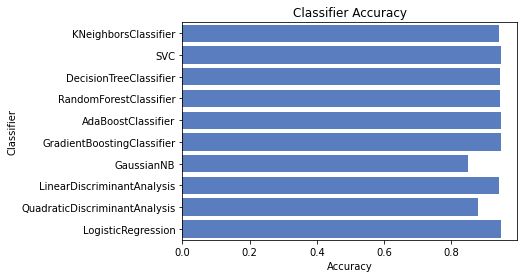

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns = log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x = 'Accuracy', y = 'Classifier', data = log, color = "b")
log

In [10]:
import pickle
import json
import pandas as pd
from sklearn.svm import SVC

from utils.dataloader import DataLoader 
from settings.constants import TRAIN_CSV


with open('settings/specifications.json') as f:
    specifications = json.load(f)

raw_train = pd.read_csv(TRAIN_CSV)
x_columns = specifications['description']['X']
y_column = specifications['description']['y']

X_raw = raw_train[x_columns]

loader = DataLoader()
loader.fit(X_raw)
X = loader.load_data()
y = raw_train.stroke

model = SVC()
model.fit(X, y)
with open('models/SVC.pickle', 'wb')as f:
    pickle.dump(model, f)

In [11]:
import pickle
import json
import pandas as pd
from sklearn.svm import SVC

from utils.dataloader import DataLoader 
from settings. constants import VAL_CSV


with open('settings/specifications.json') as f:
    specifications = json.load(f)

x_columns = specifications['description']['X']
y_column = specifications['description']['y']

raw_val = pd.read_csv(VAL_CSV)
x_raw = raw_val[x_columns]

loader = DataLoader()
loader.fit(x_raw)
X = loader.load_data()
y = raw_val.stroke

loaded_model = pickle.load(open('models/SVC.pickle', 'rb'))
loaded_model.score(X, y)

0.9579256360078278